In [1]:
import sys
# Aggiungi il percorso della cartella che contiene utils.py a sys.path
sys.path.append('../../utils')

In [2]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from utils import save_plot

In [3]:
MONK_TASK = 3

In [4]:
TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'SVM')
MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

In [5]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [6]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [7]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_3,feature_6,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4
0,1,1,2,True,False,False,True,False,False,True,False,False,True,False,False,False
1,1,1,1,True,False,False,True,False,False,True,False,False,False,True,False,False
2,1,1,2,True,False,False,True,False,False,True,False,False,False,True,False,False
3,0,1,1,True,False,False,True,False,False,True,False,False,False,False,True,False
4,0,1,1,True,False,False,True,False,False,True,False,False,False,False,False,True


In [8]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [9]:
from sklearn.svm import SVC

model = SVC(random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10, 100]
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'svc__degree': [2, 3, 4],
        'svc__coef0': [0.0, 0.1, 0.5, 1]
    },
    {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'svc__coef0': [0.0, 0.1, 0.5, 1]
    }
]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 344 candidates, totalling 1720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 10, 100],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.1, 1, 10, 100],
                          'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [0.1, 1, 10, 100],
                          'svc__coef0': [0.0, 0.1, 0.5, 1],
                          'svc__degree': [2, 3, 4],
                          'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'svc__kernel': ['poly']},
                         {'svc__C': [0.1, 1, 10, 100],
                          'svc__coef0': [0.0, 0.1, 0.5, 1],
                          'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'svc__kernel': ['sigmoid']}],
             scoring='accuracy', verbose=2)

In [11]:
from sklearn.metrics import accuracy_score, classification_report

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters:  {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best accuracy:  0.9339999999999999
Test set accuracy:  0.9722222222222222
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



# Learning curve

In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

[learning_curve] Training set sizes: [ 9 32 53 75 97]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

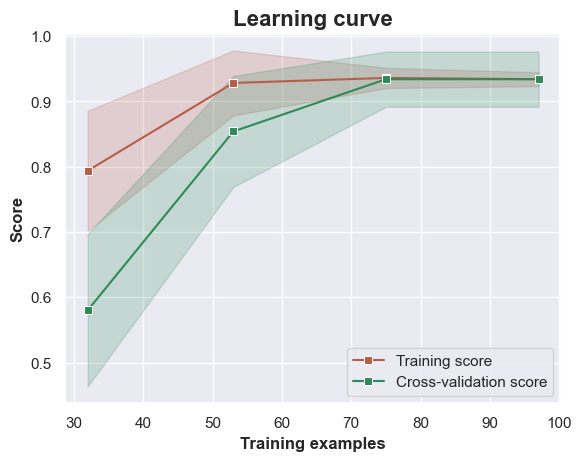

In [14]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Save model

In [15]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'SVM_model.joblib')
dump(final_model, model_path, compress=3)

['../../../trained_models/monk/task-3/SVM_model.joblib']